This notebook tests a number of methods for MLD_ts.py

In [1]:
# dependencies
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import zarr
import dask

from fastjmd95 import jmd95numba 

In [2]:
def llc_latlon_box_indices(
    LLC,
    lat_center,
    lon_center,
    degree_extent):

    half = degree_extent / 2.0

    lat_min = lat_center - half
    lat_max = lat_center + half
    lon_min = lon_center - half
    lon_max = lon_center + half

    XC = LLC["XC"]
    YC = LLC["YC"]

    face_boxes = {}

    for face in XC.face.values:
        xc = XC.sel(face=face)
        yc = YC.sel(face=face)

        # mask points inside the lat/lon box
        mask = (
            (yc >= lat_min) & (yc <= lat_max) &
            (xc >= lon_min) & (xc <= lon_max))

        if not mask.any():
            continue

        # get i/j indices where mask is True
        jj, ii = np.where(mask.values)

        j_start = int(jj.min())
        j_end   = int(jj.max()) + 1
        i_start = int(ii.min())
        i_end   = int(ii.max()) + 1

        face_boxes[int(face)] = (j_start, j_end, i_start, i_end)

    return face_boxes

In [4]:
t_0 = 432
t_1 = t_0 + (24*32)#(365*24) 


In [ ]:
LLC_full = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

# select [i,j] spatial box, face, temporal subset
boxes = llc_latlon_box_indices(
LLC_full,
lat_center=lat_center,
lon_center=lon_center,
degree_extent=degree_extent)

subs = []
for face, (j0, j1, i0, i1) in boxes.items():
    subs.append(
        LLC_full.isel(face=face, j=slice(j0, j1), i=slice(i0, i1))
    )

LLC_sub = xr.concat(subs, dim="face")

# select temporal extent, chunk: k should be full-column per chunk for .min(dim="k"
LLC_sub = LLC_sub.isel(time=slice(t_0,t_1)).chunk({'time': -1, 'k': -1,'i': 96, 'j': 96})

"""
4. Follow code from https://github.com/abodner/submeso_param_net/blob/main/scripts/preprocess_llc4320/preprocess.py
    to calculate the MLD
"""
# reference density 
rho0 = 1025 #kg/m^3

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0 = jmd95numba.rho(LLC_sub.Salt, LLC_sub.Theta,0) - rho0

# sigma0 at 10m depth for reference, no broadcasting
sigma0_10m = sigma0.isel(k=6)
delta_sigma = sigma0 - sigma0_10m

MLD_pixels = LLC_sub.Z.broadcast_like(sigma0).where(delta_sigma<=0.03).min(dim="k",skipna=True)

# average MLD over the box, weight by surface area
area = LLC_sub['rA']
MLD = (MLD_pixels * area).sum(dim=['i','j','face']) / area.sum(dim=['i','j','face'])

In [4]:
# open llc
llc = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

In [44]:
llc.Z.values

array([-5.00000e-01, -1.57000e+00, -2.79000e+00, -4.18500e+00,
       -5.78000e+00, -7.59500e+00, -9.66000e+00, -1.20100e+01,
       -1.46800e+01, -1.77050e+01, -2.11250e+01, -2.49900e+01,
       -2.93450e+01, -3.42400e+01, -3.97250e+01, -4.58550e+01,
       -5.26900e+01, -6.02800e+01, -6.86850e+01, -7.79650e+01,
       -8.81750e+01, -9.93700e+01, -1.11600e+02, -1.24915e+02,
       -1.39365e+02, -1.54990e+02, -1.71825e+02, -1.89900e+02,
       -2.09235e+02, -2.29855e+02, -2.51770e+02, -2.74985e+02,
       -2.99505e+02, -3.25320e+02, -3.52420e+02, -3.80790e+02,
       -4.10410e+02, -4.41255e+02, -4.73305e+02, -5.06540e+02,
       -5.40935e+02, -5.76465e+02, -6.13110e+02, -6.50855e+02,
       -6.89685e+02, -7.29595e+02, -7.70585e+02, -8.12660e+02,
       -8.55835e+02, -9.00135e+02, -9.45595e+02], dtype=float32)

In [41]:
llc['time.month'].values

array([ 9,  9,  9, ..., 11, 11, 11], shape=(10311,))

In [6]:
time = llc.time.values

In [29]:
time_sub = time[432:(365*24)]

In [37]:
months

array(['2011-10-01T00:00:00.000000000', '2011-10-31T00:00:00.000000000',
       '2011-11-30T00:00:00.000000000', '2011-12-30T00:00:00.000000000',
       '2012-01-29T00:00:00.000000000', '2012-02-28T00:00:00.000000000',
       '2012-03-29T00:00:00.000000000', '2012-04-28T00:00:00.000000000',
       '2012-05-28T00:00:00.000000000', '2012-06-27T00:00:00.000000000',
       '2012-07-27T00:00:00.000000000', '2012-08-26T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [34]:
months = time_sub[::30*24]

In [5]:
30-9

21

In [3]:
# first define a helper function to rotate plots for N-S/vertical alignment
def rotate_axes_90_clockwise(ax):
    """
    Robustly rotate a Matplotlib Axes 90 degrees clockwise by:
      - rendering the figure to an RGBA buffer,
      - cropping the pixels belonging to the given Axes,
      - rotating the image 90 deg clockwise,
      - placing the rotated image back into the figure at the same axes position,
      - removing the original Axes.

    Notes:
    - This rasterizes the axis contents (the result is an image, not vector art).
    - Colorbars or other axes that live outside the target `ax` are left alone.
    - Works reliably for full grids or arbitrary subsets.
    """
    fig = ax.figure

    # Force draw so renderer & sizes are correct
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # Get pixel bbox of the axes (in display coordinates) via renderer-aware call
    bbox = ax.get_window_extent(renderer=renderer)  # Bbox in display (pixel) coords

    # Grab the full figure RGBA buffer (H x W x 4)
    buf = np.asarray(renderer.buffer_rgba())  # returns an (H,W,4) uint8 array

    H, W = buf.shape[0], buf.shape[1]

    # Convert bbox to integer pixel coords and crop.
    # Note: Bbox y coords are in display coordinates with origin at lower-left.
    x0, x1 = int(np.floor(bbox.x0)), int(np.ceil(bbox.x1))
    y0, y1 = int(np.floor(bbox.y0)), int(np.ceil(bbox.y1))

    # Convert to numpy row indices (origin at top-left)
    row0 = max(0, H - y1)
    row1 = min(H, H - y0)
    col0 = max(0, x0)
    col1 = min(W, x1)

    if row1 <= row0 or col1 <= col0:
        raise RuntimeError("Calculated zero-size axes crop — renderer/coords inconsistent.")

    axes_img = buf[row0:row1, col0:col1, :].copy()  # copy to be safe

    # Rotate 90 degrees clockwise. np.rot90 rotates counterclockwise, so use k=-1 (or k=3).
    rotated = np.rot90(axes_img, k=-1)

    # Create a new axes in the same figure position (figure coords) and show the rotated image.
    # We must compute the original axes position in figure coordinates:
    fig_x0, fig_y0, fig_w, fig_h = ax.get_position().bounds

    # Add overlaid axes and show the rotated image
    new_ax = fig.add_axes([fig_x0, fig_y0, fig_w, fig_h], anchor='C')  # same place
    new_ax.imshow(rotated, origin='upper', aspect='auto')
    new_ax.set_axis_off()

    # Remove the original axes (so only rotated image remains)
    fig.delaxes(ax)

    # Force redraw
    fig.canvas.draw()
    return new_ax

# function to get i,j indices from target lat/lon vals
def i_j_from_lat_lon(coord_centers, num_boxes, coord_min):
    i = []
    j = []
    for box in range(int(num_boxes)):
        # get lat/lon in increments
        target = coord_min + 0.1 * box

        # get index closest to lat/lon targets
        dist = np.abs(coord_centers - target)
        flat_idx = np.nanargmin(dist)
        i_, j_ = np.unravel_index(flat_idx, coord_centers.shape)
        
        i.append(int(i_)), j.append(int(j_))
    return i, j

# function to get lat/lon vals from i, j indices
def lat_lon_from_i_j(LLC):
    lats = []
    lons = []
    lats.append(LLC['YC'][0,:].values)
    lons.append(LLC['XC'][:,0].values)

    return lats, lons

Let's define a function to index a box in the data using lat/lon (XC, YC)

In [4]:
# build i,j,face index for a lat/lon spatial box about central lat/lon coord for llc4320
def llc_latlon_box_indices(
    LLC,
    lat_center,
    lon_center,
    degree_extent):

    half = degree_extent / 2.0

    lat_min = lat_center - half
    lat_max = lat_center + half
    lon_min = lon_center - half
    lon_max = lon_center + half

    XC = LLC["XC"]
    YC = LLC["YC"]

    face_boxes = {}

    for face in XC.face.values:
        xc = XC.sel(face=face)
        yc = YC.sel(face=face)

        # mask points inside the lat/lon box
        mask = (
            (yc >= lat_min) & (yc <= lat_max) &
            (xc >= lon_min) & (xc <= lon_max))

        if not mask.any():
            continue

        # get i/j indices where mask is True
        jj, ii = np.where(mask.values)

        j_start = int(jj.min())
        j_end   = int(jj.max()) + 1
        i_start = int(ii.min())
        i_end   = int(ii.max()) + 1

        face_boxes[int(face)] = (j_start, j_end, i_start, i_end)

    return face_boxes

In [5]:
# apply to llc
boxes = llc_latlon_box_indices(
    llc,
    lat_center=39.0,
    lon_center=158.0,
    degree_extent=1.0
)

for face, (j0, j1, i0, i1) in boxes.items():
    llc_box = llc.isel(face=face, j=slice(j0, j1), i=slice(i0, i1))

In [6]:
# extract box i,j extents
i_0 = llc_box.i.values.min()
i_1 = llc_box.i.values.max()
j_0 = llc_box.j.values.min()
j_1 = llc_box.j.values.max()

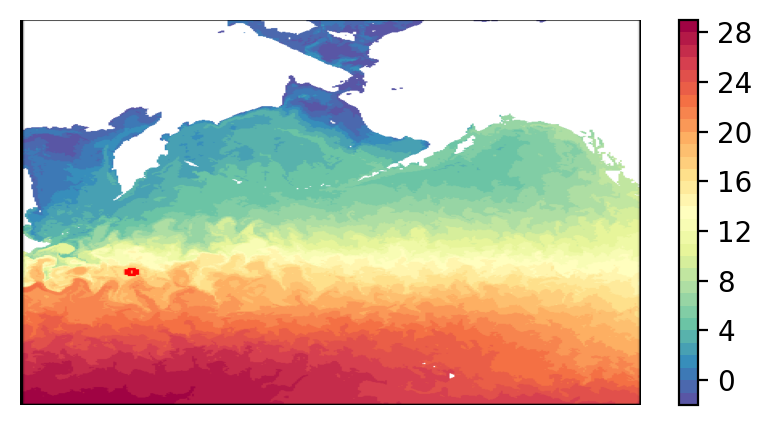

In [7]:
# let's visualize loc of interest
llc_sub = llc.isel(time=2000,face=7, k=14)
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_sub['Theta']['i'], llc_sub['Theta']['j'], llc_sub['Theta'], cmap="Spectral_r",vmin=np.min(llc_sub['Theta']).values,vmax=np.max(llc_sub['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

rotate_axes_90_clockwise(ax)

plt.show()

In [8]:
llc_box_sub = llc_box.isel(time=slice(0,24))

In [9]:
# code adapted from https://github.com/abodner/submeso_param_net/blob/main/scripts/preprocess_llc4320/preprocess.py
# reference density 
rho0 = 1025 #kg/m^3

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0 = jmd95numba.rho(llc_box_sub.Salt, llc_box_sub.Theta,0) - rho0

# sigma0 at 10m depth for reference, no broadcasting
sigma0_10m = sigma0.isel(k=6)
delta_sigma = sigma0 - sigma0_10m

MLD_pixels = llc_box_sub.Z.broadcast_like(sigma0).where(delta_sigma<=0.03).min(dim="k",skipna=True)

In [10]:
# average MLD over the box
MLD = MLD_pixels.mean(dim=['i','j'])

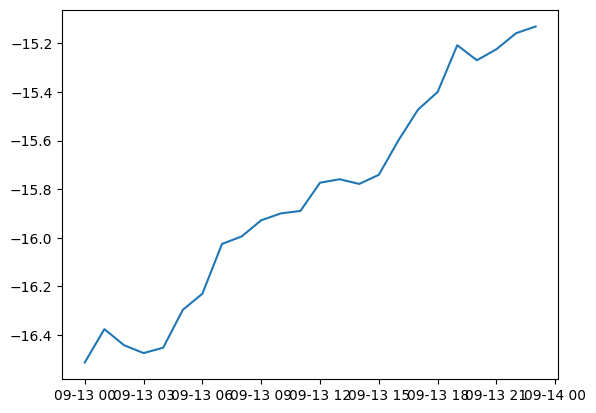

In [11]:
plt.plot(MLD.time, MLD.values)

In [54]:
loc = 'Kuroshio'
lat_center = 39
lon_center = 158
degree_extent = 1.0

slurm_job_name = 'test'

# ------------ 1 deg Agulhas Current centered @ 43°S, 14°E
# loc = 'Agulhas'
# lat_center = -43
# lon_center = 14
# degree_extent = 1.0

# ------------ 1 deg Gulf Stream centered @ 43°S, 14°E
# loc = 'Gulf'
# lat_center = 39
# lon_center = -66
# degree_extent = 1.0

# set temporal extent
t_0 = 0
t_1 = 24 * 1

# exp name
exp_name = str(slurm_job_name) + f'_{loc}' + f'_{degree_extent}deg'

"""
3. open and subset LLC4320
"""

# open LLC4320
LLC_full = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

# select [i,j] spatial box, face, temporal subset
boxes = llc_latlon_box_indices(
LLC_full,
lat_center=lat_center,
lon_center=lon_center,
degree_extent=degree_extent)

subs = []
for face, (j0, j1, i0, i1) in boxes.items():
    subs.append(
        LLC_full.isel(face=face, j=slice(j0, j1), i=slice(i0, i1))
    )

LLC_sub = xr.concat(subs, dim="face")

# select temporal extent, chunk
LLC_sub = LLC_sub.isel(time=slice(t_0,t_1)).chunk({'time': -1, 'i': 96, 'j': 96})

"""
4. Follow code from https://github.com/abodner/submeso_param_net/blob/main/scripts/preprocess_llc4320/preprocess.py
    to calculate the MLD
"""
# reference density 
rho0 = 1025 #kg/m^3

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0 = jmd95numba.rho(LLC_sub.Salt, LLC_sub.Theta,0) - rho0

# sigma0 at 10m depth for reference
sigma0_10m = sigma0.isel(k=6).broadcast_like(sigma0)
delta_sigma = sigma0 - sigma0_10m

MLD_pixels = LLC_sub.Z.broadcast_like(sigma0).where(delta_sigma<=0.03).min(dim="k",skipna=True)

# average MLD over the box
MLD = MLD_pixels.mean(dim=['i','j','face'])

In [55]:
MLD

<xarray.DataArray 'Z' (time: 24)> Size: 96B
dask.array<mean_agg-aggregate, shape=(24,), dtype=float32, chunksize=(24,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 192B 2011-09-13 ... 2011-09-13T23:00:00

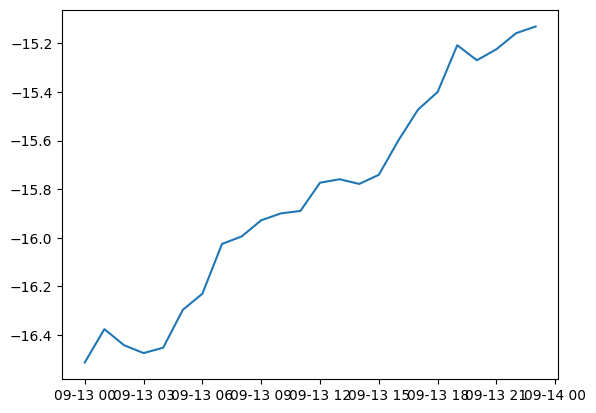

In [56]:
plt.plot(MLD.time, MLD.values)